# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
from __future__ import print_function
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
import time


%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 16.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [3]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.338386
sanity check: 2.302585


$$f(x, W) = - \log{(truescore(\frac{e^{X.dot(W)}}{sum (e^{(X.dot(W))})})}) $$

In [4]:
reg = 5e1
loss = 0
dW= np.zeros(W.shape)
scores = np.zeros((X_dev.shape[0], W.shape[1]))
for i in range(0, X_dev.shape[0]):
    scores[i, :] = X_dev[i, :].dot(W) #1
    scores[i, :] -= np.max(scores[i, :]) # for numerical stabilization
    scores_exp = np.exp(scores[i, :])
    sum_scores_exp = np.sum(scores_exp)
    softmax = scores_exp / sum_scores_exp #2 This is softmax function
    loss += -np.log(softmax[y_dev[i]]) # this is loss
    for j in range(0, W.shape[1]):
        dW[:, j] += X_dev[i]*(softmax[j] - (j == y_dev[i])) 
loss = loss / X_dev.shape[0]
loss += reg*np.sum(W*W)
dW = dW / X_dev.shape[0]
dW += reg*2*W
print(loss)
#print(loss)
print(dW)

2.3537385503042527
[[-2.45416305e+00 -1.61254691e+00  1.64767174e+00 ...  1.86837457e+00
  -2.82237565e+00 -2.71402233e+00]
 [-3.26373351e+00 -1.56310909e+00  1.39191601e+00 ...  1.22939176e+00
  -3.59033065e+00 -3.22532396e+00]
 [-4.92183170e+00 -1.94203341e+00  2.21889887e+00 ...  1.20023624e+00
  -5.88304411e+00 -4.14362197e+00]
 ...
 [-1.38718196e-01 -8.41378341e-04  8.45679636e-01 ... -1.50179658e+00
   1.03784271e+00 -2.16219577e+00]
 [-1.66340328e+00 -8.69627434e-01  2.33249695e+00 ...  6.11984333e-01
  -1.46462978e+00 -2.74263887e+00]
 [-3.22585625e-03  1.55946795e-02 -2.31414738e-02 ... -4.97642771e-02
   1.61562334e-03  1.37701568e-02]]


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Initially all weights are close to 0, so scores. If we exponentiate the scores, we get 1 for each class and example. Then we normalize them, they are going to be 1/number of classes. And loss is -log(1/number of classes) which in this case is -log(0.1)*


In [5]:
np.random.seed(18)
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 0.795674 analytic: 0.795674, relative error: 5.974365e-08
numerical: 2.727825 analytic: 2.727825, relative error: 6.909194e-09
numerical: 1.326593 analytic: 1.326593, relative error: 3.834986e-08
numerical: -0.714127 analytic: -0.714128, relative error: 4.618940e-08
numerical: 1.394798 analytic: 1.394798, relative error: 4.069844e-09
numerical: 2.824643 analytic: 2.824643, relative error: 1.549565e-08
numerical: -0.506977 analytic: -0.506977, relative error: 1.004317e-07
numerical: 1.122490 analytic: 1.122490, relative error: 3.639918e-08
numerical: -1.536088 analytic: -1.536088, relative error: 2.995589e-10
numerical: 0.600785 analytic: 0.600784, relative error: 4.221150e-08
numerical: 2.284369 analytic: 2.284369, relative error: 1.176980e-08
numerical: -1.939292 analytic: -1.939292, relative error: 2.561262e-08
numerical: 0.838377 analytic: 0.838377, relative error: 1.338185e-08
numerical: 4.323957 analytic: 4.323957, relative error: 4.680638e-09
numerical: -0.257205 analy

In [6]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.338386e+00 computed in 0.164420s
vectorized loss: 2.338386e+00 computed in 0.004033s
Loss difference: 0.000000
Gradient difference: 0.000000


In [7]:
#vectorized loss
loss = 0.0
dW = np.zeros_like(W)
reg = 0.000005
#############################################################################
# TODO: Compute the softmax loss and its gradient using no explicit loops.  #
# Store the loss in loss and the gradient in dW. If you are not careful     #
# here, it is easy to run into numeric instability. Don't forget the        #
# regularization!                                                           #
#############################################################################
N = X_dev.shape[0]
scores = X_dev.dot(W)
scores -= np.max(scores, axis = 1).reshape(N, 1) #for numerical stability
exp = np.exp(scores)
softmax = exp / exp.sum(axis=1).reshape(N, 1)
true_class_probs = softmax[range(0, N), y_dev]
losses = -np.log(true_class_probs)

#total loss
loss = np.sum(losses) / N  
# add regularization
loss += reg*np.sum(W*W)
print(loss)

#vectorized dW
gama = np.zeros(softmax.shape)
gama[range(0, N), y_dev] = 1
dW = X_dev.T.dot(softmax - gama)
dW = dW / X_dev.shape[0]
dW += 2*reg*W 
print(dW)

2.338385971480198
[[-2.45902698e+00 -1.58907416e+00  1.65531172e+00 ...  1.87039977e+00
  -2.82271155e+00 -2.71394321e+00]
 [-3.25037398e+00 -1.55151819e+00  1.39275423e+00 ...  1.22385362e+00
  -3.58704523e+00 -3.22519262e+00]
 [-4.90262019e+00 -1.94268969e+00  2.20503549e+00 ...  1.17994620e+00
  -5.89143916e+00 -4.15472351e+00]
 ...
 [-1.45679956e-01 -5.25943616e-04  8.48302855e-01 ... -1.48801381e+00
   1.03400445e+00 -2.18147410e+00]
 [-1.66351733e+00 -8.70008250e-01  2.33004007e+00 ...  6.10650817e-01
  -1.48176302e+00 -2.73729543e+00]
 [ 3.64320442e-03  1.49358851e-02 -1.47910038e-02 ... -3.67153648e-02
  -4.48892610e-03  1.30132873e-02]]


In [8]:
from cs231n.classifiers import Softmax
softmax = Softmax()
tic = time.time()
loss_hist = softmax.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 771.796035
iteration 100 / 1500: loss 283.418456
iteration 200 / 1500: loss 105.122459
iteration 300 / 1500: loss 39.695857
iteration 400 / 1500: loss 15.892416
iteration 500 / 1500: loss 7.117263
iteration 600 / 1500: loss 3.937407
iteration 700 / 1500: loss 2.746157
iteration 800 / 1500: loss 2.387738
iteration 900 / 1500: loss 2.204839
iteration 1000 / 1500: loss 2.082849
iteration 1100 / 1500: loss 2.075393
iteration 1200 / 1500: loss 2.103925
iteration 1300 / 1500: loss 2.036888
iteration 1400 / 1500: loss 2.048126
That took 4.771427s


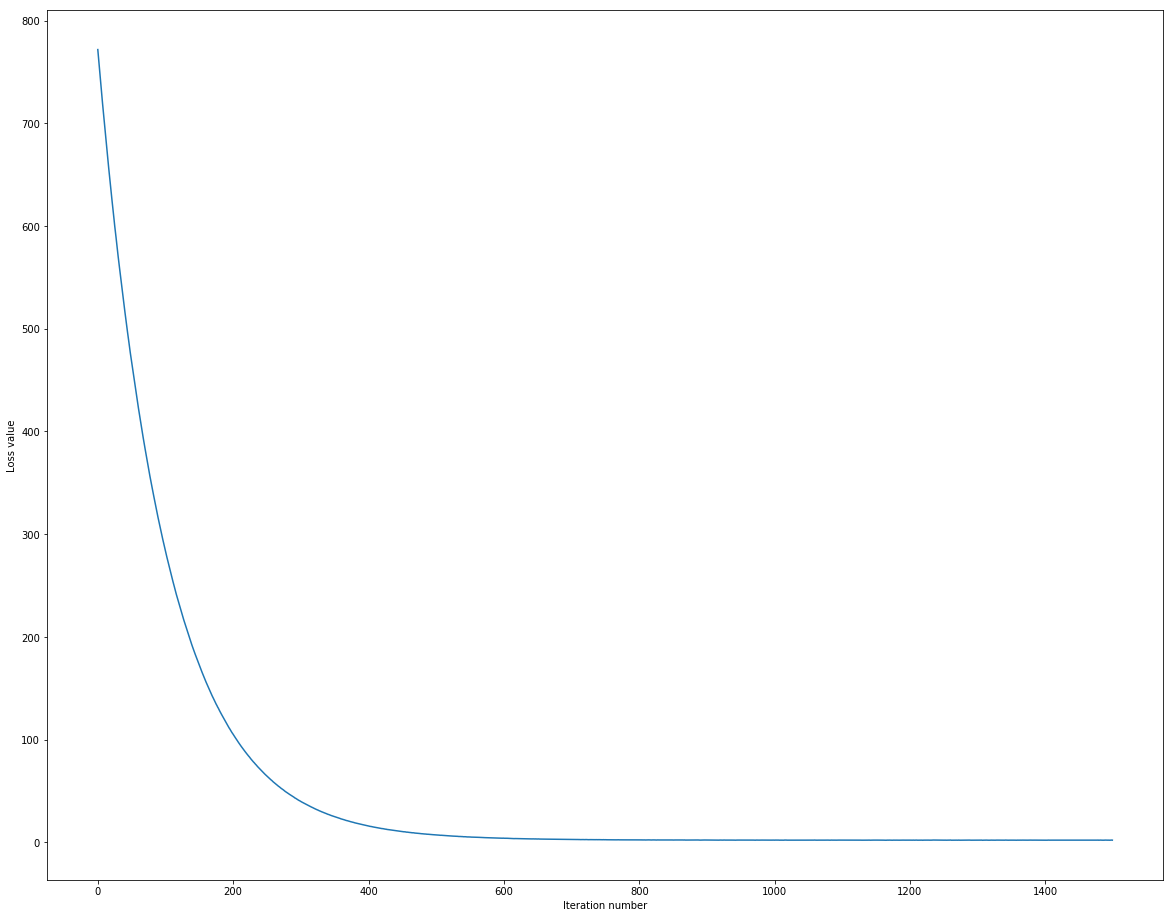

In [9]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.rcParams['figure.figsize'] = (20.0, 16.0)
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

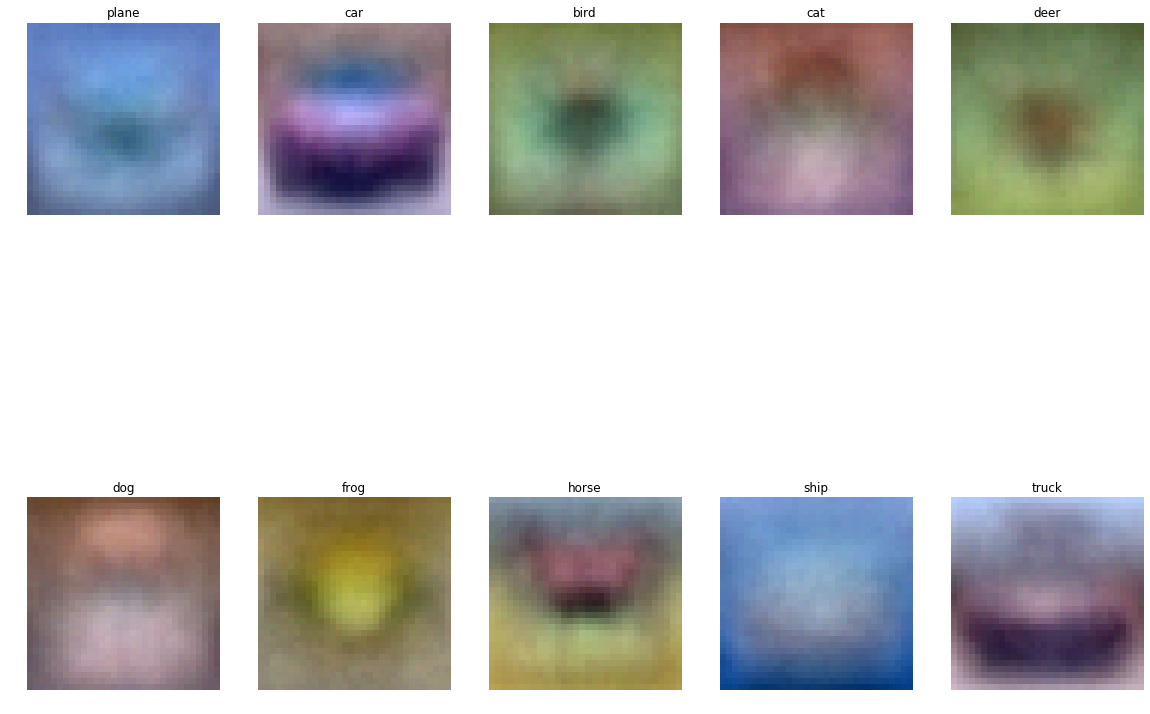

In [10]:
# Visualize the learned weights for each class
w = softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

In [11]:
# training and validation set
y_train_pred = softmax.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = softmax.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.325061
validation accuracy: 0.340000


In [12]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
# Your code
learning_rates = [1e-7, 5e-7, 8e-7, 3e-8]
regularization_strengths = [1e3, 2.5e4, 5e4, 1e5, 5e5]

for lr in learning_rates:
    for reg in regularization_strengths:
        softmax = None
        softmax = Softmax()
        loss_hist = softmax.train(X_train, y_train, learning_rate=lr, reg=reg,
                              num_iters=1500, verbose=True) 
        y_train_pred = softmax.predict(X_train)
        train_accuracy = np.mean(y_train == y_train_pred)
        y_val_pred = softmax.predict(X_val)
        valid_accuracy = np.mean(y_val == y_val_pred)
        results[(lr, reg)] = (train_accuracy, valid_accuracy)
        if valid_accuracy > best_val:
            best_val = valid_accuracy
            best_softmax = softmax
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 34.374684
iteration 100 / 1500: loss 32.780000
iteration 200 / 1500: loss 30.928097
iteration 300 / 1500: loss 30.083680
iteration 400 / 1500: loss 28.780710
iteration 500 / 1500: loss 27.352867
iteration 600 / 1500: loss 26.565451
iteration 700 / 1500: loss 25.576125
iteration 800 / 1500: loss 24.492410
iteration 900 / 1500: loss 23.464399
iteration 1000 / 1500: loss 22.517286
iteration 1100 / 1500: loss 21.637620
iteration 1200 / 1500: loss 20.708788
iteration 1300 / 1500: loss 20.066836
iteration 1400 / 1500: loss 19.392901
iteration 0 / 1500: loss 770.188416
iteration 100 / 1500: loss 282.629767
iteration 200 / 1500: loss 104.859671
iteration 300 / 1500: loss 39.606528
iteration 400 / 1500: loss 15.840609
iteration 500 / 1500: loss 7.107696
iteration 600 / 1500: loss 3.913858
iteration 700 / 1500: loss 2.706302
iteration 800 / 1500: loss 2.313247
iteration 900 / 1500: loss 2.185419
iteration 1000 / 1500: loss 2.076877
iteration 1100 / 1500: loss 2.092950
it

iteration 0 / 1500: loss 35.862189
iteration 100 / 1500: loss 34.606116
iteration 200 / 1500: loss 34.236354
iteration 300 / 1500: loss 33.384726
iteration 400 / 1500: loss 32.796809
iteration 500 / 1500: loss 32.172192
iteration 600 / 1500: loss 31.611386
iteration 700 / 1500: loss 31.525869
iteration 800 / 1500: loss 30.992283
iteration 900 / 1500: loss 30.532043
iteration 1000 / 1500: loss 30.012302
iteration 1100 / 1500: loss 29.654417
iteration 1200 / 1500: loss 29.345850
iteration 1300 / 1500: loss 29.096720
iteration 1400 / 1500: loss 28.571998
iteration 0 / 1500: loss 771.709474
iteration 100 / 1500: loss 570.937170
iteration 200 / 1500: loss 422.729004
iteration 300 / 1500: loss 313.428108
iteration 400 / 1500: loss 232.482354
iteration 500 / 1500: loss 172.502322
iteration 600 / 1500: loss 128.043389
iteration 700 / 1500: loss 95.373814
iteration 800 / 1500: loss 71.154553
iteration 900 / 1500: loss 53.213286
iteration 1000 / 1500: loss 39.881282
iteration 1100 / 1500: loss 3

In [13]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.384000


**Inline Question** - *True or False*

It's possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

*Your answer*: True

*Your explanation*: Because svm loss only cares about true class being higher than other classes by some margin. If true class score is higher than other scores by that specific margin, there won't be any change to loss. 

On the other hand softmax always want to increase probability of correct class so adding a new example always changes loss. 

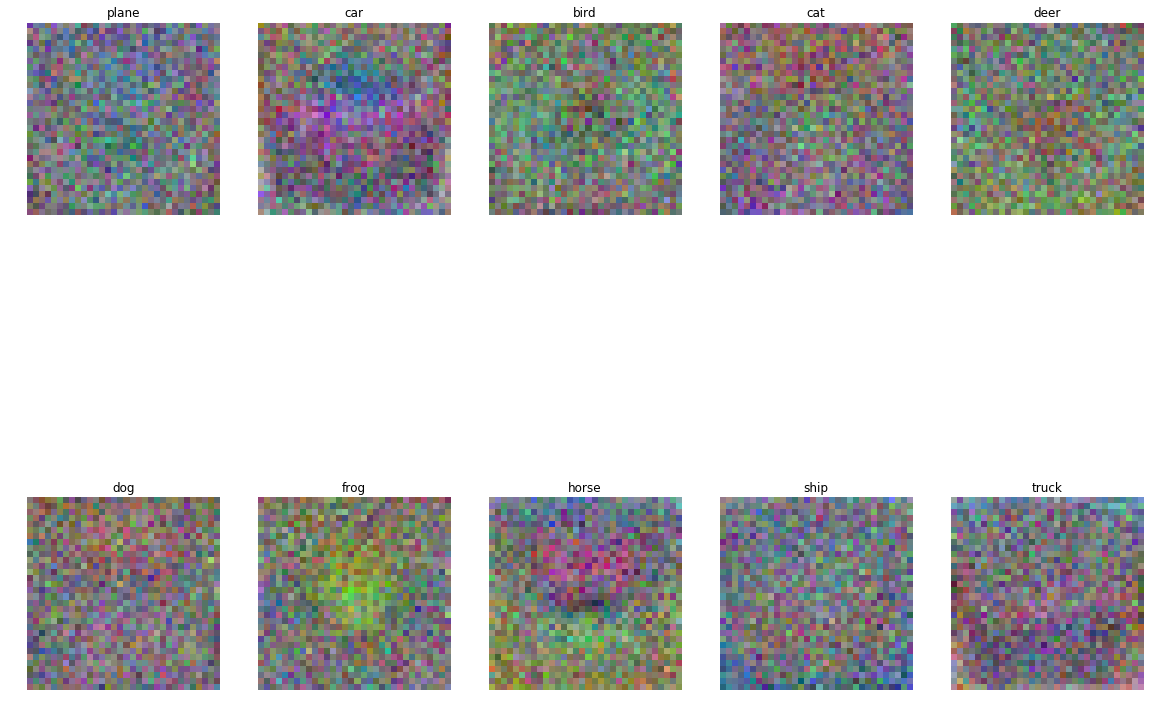

In [14]:
# Visualize the learned weights for each class
plt.rcParams['figure.figsize'] = (20.0, 16.0)
best_w = best_softmax.W[:-1,:] # strip out the bias
best_w = best_w.reshape(32, 32, 3, 10)

best_w_min, best_w_max = np.min(best_w), np.max(best_w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    best_wimg = 255.0 * (best_w[:, :, :, i].squeeze() - best_w_min) / (best_w_max - best_w_min)
    plt.imshow(best_wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])